In [1]:
library(tidyverse)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Comparing protein-protein interaction (PPI) predictions with a sequence-based and structure-based tool
This notebook analyzes PPIs for tick:human protein pairs that are predicted to interact either based on functional annotations or experimental evidence of human proteome-wide PPI networks. Two tools were used to generate PPI preditions. D-script is a sequence-based deep learning tool that compares your input sequence pairs to sets of experimentally validated sequences known to interact and provides a confidence score, where confidence scores above 0.5 are a positive hits. Alphafold multimer (also referred to as AF-multimer) is a structure-based tool that makes predictions of the 3D structures of the two input sequences and the confidence of their interaction point. AF-multimer provides two metrics specific to multimer confidence: pTM and ipTM. A ranking confidence score is calculated from these two metrics, where `ranking confidence = (0.2 * pTM) + (0.8 * iPTM)`. A ranking confidence scores equal to or above 0.75 is considered a high confidence score. 

In [2]:
# serine protease uniprot metadata
serine_protease_metadata <- read.table("../datasheets/uniprotkb_UP000005640_serine_protease_2024_03_05.tsv", sep = "\t", header = TRUE) %>% 
    select(Entry, Reviewed, Entry.Name, Protein.names, Length)
colnames(serine_protease_metadata) <- c("uniprot_id", "reviewed", "uniprot_name", "annotation", "length")

# serine protease dscript results
serine_protease_dscript_results <- read.table("../outputs/protein_protein_interaction_results/2024-03-20-Amblyomma-americanum-1.4-serine-protease-dscript-comps.tsv", sep="\t", col.names = c("amblyomma_protein", "uniprot_id", "dscript_confidence_score")) %>% 
    mutate(uniprot_id = str_extract(uniprot_id, "(?<=\\|)[^|]+(?=\\|)"))

# serine protease af-multimer results
serine_protease_afmultimer_results <- read.csv("../outputs/protein_protein_interaction_results/Amblyomma-americanum-94090-1.4-serine-protease-initial-afmultimer-screen.csv")
colnames(serine_protease_afmultimer_results) <- c("amblyomma_protein", "uniprot_id", "pTM", "ipTM", "afmultimer_ranking_confidence")

Joining with `by = join_by(amblyomma_protein, uniprot_id)`
Joining with `by = join_by(uniprot_id)`


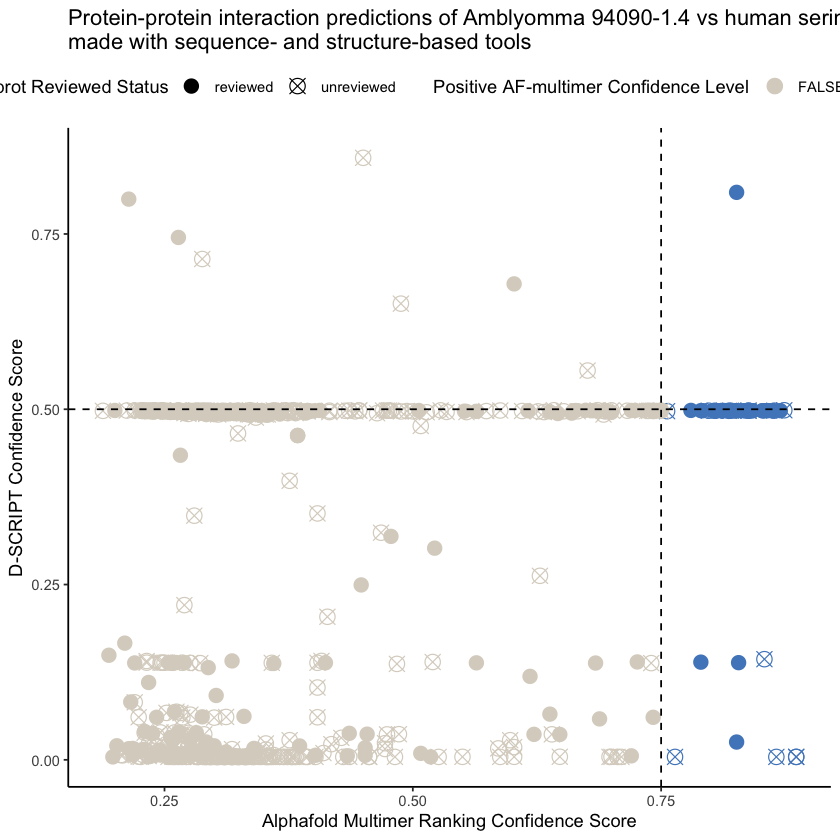

In [3]:
# combine dscript and afmultimer results with uniprot metadata
serine_protease_combined_results <- left_join(serine_protease_afmultimer_results, serine_protease_dscript_results) %>% 
    left_join(serine_protease_metadata)

# plot comparison with different colors for positive AFmultimer and shapes for reviewed/unreviewed
serine_protease_dscript_afmultimer_comparisons_plot <- serine_protease_combined_results %>% 
    ggplot(aes(x=afmultimer_ranking_confidence, y=dscript_confidence_score)) +
    geom_point(aes(color = afmultimer_ranking_confidence > 0.75, shape = reviewed), size = 4) +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0.75, linetype = "dashed", color = "black") +
    scale_color_manual(values = c("FALSE" = "#DAD3C7", "TRUE" = "#5088C5"), name = "Positive AF-multimer Confidence Level") +
    scale_shape_manual(values = c("reviewed" = 16, "unreviewed" = 13), name = "Uniprot Reviewed Status") +
    scale_x_continuous(breaks = seq(0, 1, by = 0.25)) +
    scale_y_continuous(breaks = seq(0, 1, by = 0.25)) +
    xlab("Alphafold Multimer Ranking Confidence Score") +
    ylab("D-SCRIPT Confidence Score") +
    labs(title = "Protein-protein interaction predictions of Amblyomma 94090-1.4 vs human serine proteases \nmade with sequence- and structure-based tools") +
    theme_classic() +
    theme(legend.position = "top")

serine_protease_dscript_afmultimer_comparisons_plot

ggsave("../outputs/figures/serine_protease_dscript_afmultimer_comparisons.png", serine_protease_dscript_afmultimer_comparisons_plot, width=10, height=8, units=c("in"))
ggsave("../outputs/figures/serine_protease_dscript_afmultimer_comparisons.pdf", serine_protease_dscript_afmultimer_comparisons_plot, width=10, height=8, units=c("in"))

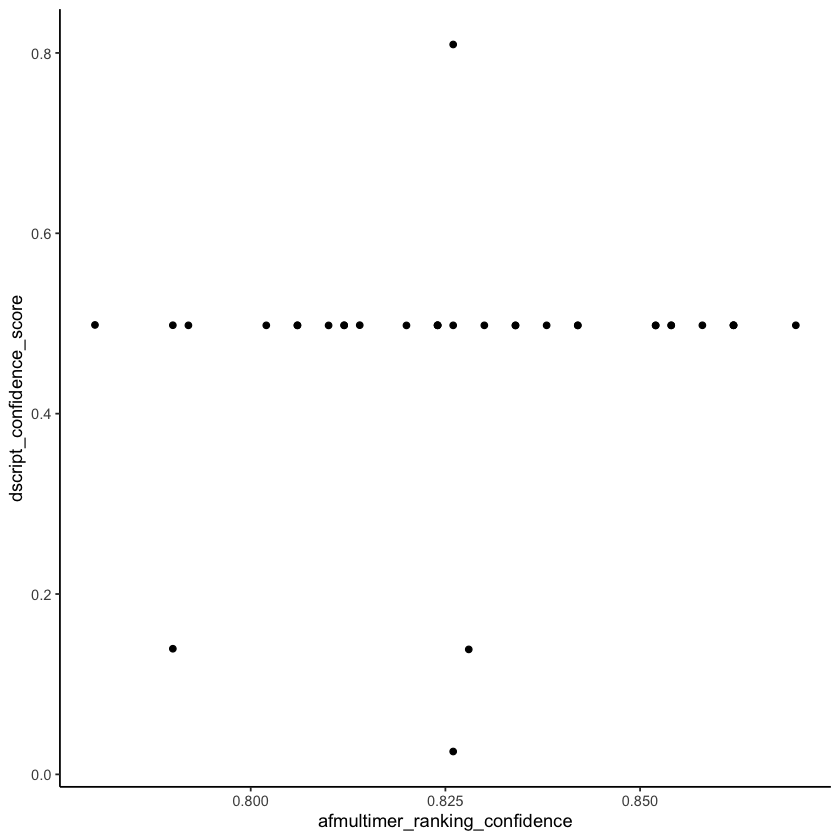

In [5]:
# filtered serine protease results for high confidence afmultimer scores
# filter for only reviewed proteins since unreviewed are mostly isoforms of the same sets of proteins that are already hits
filtered_serine_protease_results <- serine_protease_combined_results %>% 
    filter(afmultimer_ranking_confidence > .75) %>% 
    filter(reviewed == "reviewed")


# save file
write.csv(filtered_serine_protease_results, "../outputs/protein_protein_interaction_results/filtered-serine-protease-afmultimer-top-hits.csv", quote = FALSE, row.names = FALSE)

# plot comparison for filtered set of results
filtered_serine_protease_results %>% 
    ggplot(aes(x=afmultimer_ranking_confidence, y=dscript_confidence_score)) +
    geom_point() +
    theme_classic()


# Conclusions
PPI predictions from D-script and AF-multimer only agreed for one interaction, with many false positives predicted from D-script for the initial screen. Because D-script's model was developed on human-human PPIs, we concluded that this tool won't work for our purposes or be useful as an initial tool to filter down the number of comparisons to make with AF-multimer. Since AF-multimer has been successfully used for modeling cross-kingdom PPIs, particularly protease inhibitors, we moved forward with only using that tool to make predictions.

In [6]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/adairborges/miniconda3/envs/tick_ppi/lib/libopenblasp-r0.3.29.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.4 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [5] purrr_1.0.4     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
 [9] ggplot2_3.5.2   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.9.1    compiler_4.3.3    crayon_1.5.3     
 [5] tidyselect_1.2.1  IRdisplay_1.1     textshaping_1.0.0 systemfonts_1.2.1
 [9] scales_1.3.0      uuid_1.2-1        fastmap_1.2.0     IRkernel_1.3.2   
[13] R6_2.6.1          labeling_0.4.3